# 模型选择、欠拟合和过拟合

通过多项式拟合来交互地探索这些概念

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

使用以下三阶多项式来生成训练和测试数据的标签：
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

看一下前2个样本

In [4]:
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-1.2756],
         [-0.2523]]),
 tensor([[ 1.0000e+00, -1.2756e+00,  8.1359e-01, -3.4594e-01,  1.1032e-01,
          -2.8145e-02,  5.9837e-03, -1.0904e-03,  1.7387e-04, -2.4643e-05,
           3.1434e-06, -3.6453e-07,  3.8749e-08, -3.8022e-09,  3.4644e-10,
          -2.9461e-11,  2.3488e-12, -1.7624e-13,  1.2490e-14, -8.3854e-16],
         [ 1.0000e+00, -2.5233e-01,  3.1836e-02, -2.6777e-03,  1.6892e-04,
          -8.5247e-06,  3.5851e-07, -1.2923e-08,  4.0762e-10, -1.1428e-11,
           2.8837e-13, -6.6151e-15,  1.3910e-16, -2.6999e-18,  4.8663e-20,
          -8.1861e-22,  1.2910e-23, -1.9163e-25,  2.6863e-27, -3.5676e-29]]),
 tensor([-1.2060,  4.4966]))

实现一个函数来评估模型在给定数据集上的损失

In [5]:
def evaluate_loss(net, data_iter, loss):  
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

定义训练函数

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

三阶多项式函数拟合(正态)

weight: [[ 4.9757376  1.1941305 -3.3881629  5.6050515]]


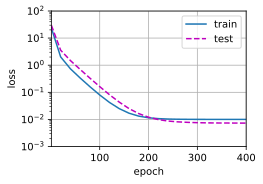

In [7]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

线性函数拟合(欠拟合)

weight: [[3.6157346 3.5507293]]


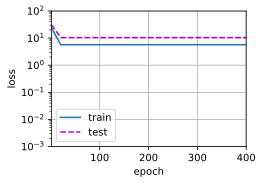

In [8]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

高阶多项式函数拟合(过拟合)

weight: [[ 4.95033550e+00  1.27921343e+00 -3.23711967e+00  5.18376970e+00
  -4.17744100e-01  1.24721706e+00 -1.42461821e-01  1.31548271e-01
   1.08938396e-01  2.64666369e-03 -1.39901012e-01 -1.92932069e-01
  -1.19168229e-01  1.04448825e-01  2.19532564e-01  1.02818757e-01
  -6.87331408e-02 -2.16461852e-01 -2.17900813e-01  3.54098938e-02]]


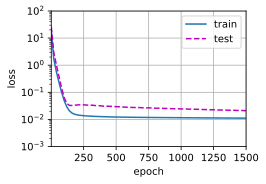

In [9]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)